# NGS: SNP calling, genoptype calling, allele frequencies, Imputation and EM algorithm

We will work on 33 European samples where we have reduced the genome so there is very little data. 

We will be looking at the default behaviour for 3 programs

| tool | SAMtools/bcftools | GATK | ANGSD |
| --- | --- | --- | --- |
| Genotype likelihood | tries to model error dependenties | simple | user specified |
| SNP caller | uses the SFS as prior | uses SFS as prior | likelihood ratio test |
| Genotype caller | MAF | ML | MAF prior |

<br>
All the programs have additional filters and additional differences. 

## Environment setup

Please change these environments accordingly

In [27]:
# shared tools and data folder
source /home/student/USER/miniconda.sh
conda activate anders
TOOL_PATH=/home/student/opt/anders # for standalone tool script including java package
SHARED_PATH=/home/tch_wyd/myname/shared # For reference database
INPUT_PATH=/home/tch_wyd/myname/inputs/imputation  # for input data

(anders) (base) (anders) (anders) (anders) (anders) 


In [2]:
# go to working folder
cd ~/
mkdir -p ~/sysu_day2_imputation
cd ~/sysu_day2_imputation
output_dir=~/sysu_day2_imputation

(anders) (anders) (anders) (anders) (anders) 


In [3]:
# set R working space
work_d <- path.expand("~/sysu_day2_imputation")
setwd(work_d)

we should have access to all files and tools if the environment is set up correctly

In [4]:
which angsd
which samtools
which bcftools
which vcftools

# Additional tools
BEAGLE4=${TOOL_PATH}/beagle.27Jan18.7e1.jar
BEAGLE5=${TOOL_PATH}/beagle.27Feb25.75f.jar
QUILT2=${TOOL_PATH}/QUILT/QUILT2.R

# Reference data
QUILT2_MAP=${SHARED_PATH}/data/hg38/CEU-chr20-final.b38.txt.gz
BEAGLE5_MAP=${SHARED_PATH}/data/plink.GRCh38.map/plink.chr20.GRCh38.rename.map
REF_GENOME=${SHARED_PATH}/data/GRCh38_full_analysis_set_plus_decoy_hla.fa

REF_VCF=${INPUT_PATH}/vcfs/CEU_ref_set.chr20.vcf.gz
TRUE_VCF=${INPUT_PATH}/vcfs/CEU_true_set.chr20.vcf.gz
EXAMPLE_VCF=${INPUT_PATH}/vcfs/example.vcf.gz
QUILT2_EXAMPLE=${INPUT_PATH}/vcfs/quilt2_all_inds.vcf.gz

# Input data
SAM_FOLDER=${INPUT_PATH}/bams
FAKE_SNPCHIP=${INPUT_PATH}/vcfs/CEU_fake_chip.chr20.vcf.gz

# you could run this to check whether files exist
ls ${BEAGLE4} ${BEAGLE5} ${BEAGLE5_MAP} ${QUILT2} ${QULT2_MAP} ${REF_GENOME} ${TRUE_VCF} ${REF_VCF} ${QUILT2_EXAMPLE} ${FAKE_SNPCHIP} ${SAM_FOLDER} 

/home/student/miniconda3/envs/anders/bin/angsd
(anders) /home/student/miniconda3/envs/anders/bin/samtools
(anders) /home/student/miniconda3/envs/anders/bin/bcftools
(anders) /home/student/miniconda3/envs/anders/bin/vcftools
(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) /home/student/opt/anders/beagle.27Feb25.75f.jar
/home/student/opt/anders/beagle.27Jan18.7e1.jar
/home/student/opt/anders/QUILT/QUILT2.R
/home/tch_wyd/myname/inputs/imputation/vcfs/CEU_fake_chip.chr20.vcf.gz
/home/tch_wyd/myname/inputs/imputation/vcfs/CEU_ref_set.chr20.vcf.gz
/home/tch_wyd/myname/inputs/imputation/vcfs/CEU_true_set.chr20.vcf.gz
/home/tch_wyd/myname/inputs/imputation/vcfs/quilt2_all_inds.vcf.gz
/home/tch_wyd/myname/shared/data/GRCh38_full_analysis_set_plus_decoy_hla.fa
/home/tch_wyd/myname/shared/data/plink.GRCh38.map/plink.chr20.GRCh38.rename.map

/home/tc

## Input formats and pata preparation

Input Reference panel. IMPUTE format hap and legend format files with reference haplotypes. These can be made from haplotype VCFs using bcftools convert --haplegendsample. Alternatively, they can be made manually. The haplotype file is a gzipped file with no header and no rownames, with one row per SNP, with one column per reference haplotype, space separated, and values of 0 (ref) and 1 (alt). The legend file is a gzipped file with no rownames, a header file including position for the physical position in 1 based coordinates, a0 for the reference allele, and a1 for the alternate allele. An optional sample file and file with samples to exclude can be useful for changing who is used in the reference panel.

Genetic map. File with genetic map information, with 3 white-space delimited columns giving position (1-based), genetic rate map in cM/Mbp, and genetic map in cM

Bams. Given as a bamlist (i.e. a file with one row per sample, the path to the bam)

(Optional) Truth data. phasefile and posfile. Useful for understanding performance. Phasefile has a header row with a name for each sample, matching what is found in the bam file. File is tab separated, one subject per column, with 0 = ref and 1 = alt, separated by a vertical bar |, e.g. 0|0 or 0|1. Note therefore this file has one more row than posfile which has no header. For posfile, this is a file with positions of where to impute, lining up one-to-one with the SNPs of phasefile. File is tab seperated with no header, one row per SNP, with col 1 = chromosome, col 2 = physical position (sorted from smallest to largest), col 3 = reference base, col 4 = alternate base. Bases are capitalized. Example first row: 11000AG

- create folders and prepare inputs

In [5]:
ls $SAM_FOLDER/NA*.bam > ${output_dir}/CEU_inds_bams.list

(anders) 


- check your data

In [6]:
samtools mpileup -b ${output_dir}/CEU_inds_bams.list | head -n 10

[mpileup] 30 samples in 30 input files
chr20	1999852	N	1	^]a	?	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*
chr20	1999853	N	1	c	?	0	*	*	0	*	*	0	*	*	1	^]c	?	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*
chr20	1999854	N	1	a	?	0	*	*	0	*	*	0	*	*	1	a	?	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*
chr20	1999855	N	1	t	?	0	*	*	0	*	*	0	*	*	1	t	?	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*
chr20	1999856	N	1	a	?	0	*	*	0	*	*	0	*	*	1	a	?	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0	*	*	0

- view the data in mpileup format and identify the columns


And you should index the fasta reference

In [7]:
## do not run. This is done for you
#samtools faidx $REF

(anders) (anders) 


## output formats
Output VCF with both SNP annotation information (see below) and per-sample genotype information. Per-sample genotype information includes the following entries: **`GT:GP:DS:HD`**

GT Phased genotypes Phased genotype, where each allele is the rounded per-haplotype posterior probability (HD below)

GP Genotype posteriors Posterior probabilities of the three genotypes given the data

DS Diploid dosage Posterior expectation of the diploid genotype i.e. the expected number of copies of the alternate allele

HD Haploid dosages Per-haplotype posterior probability of an alternate allele

Note that in QUILT, genotype posteriors (GP) and dosages (DS) are taken from the main Gibbs sampling, while the phasing results (GT and HD) are taken from an additional special phasing Gibbs sample. As such, phasing results (GT and HD) might not be consistent with genotype information (GP and DS). If consistency is necessary, note that you can create a consistent GP and DS from HD.

In [8]:
zcat ${EXAMPLE_VCF} | head -n 15 | tail -n +11

##FORMAT=<ID=HD,Number=2,Type=Float,Description="Haploid dosages">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA07000	NA07048	NA07056	NA10851	NA11829	NA11832	NA11881	NA11892	NA11930	NA11931	NA11992	NA11994	NA12043	NA12044	NA12046	NA12156	NA12272	NA12340	NA12348	NA12718	NA12749	NA12813	NA12827	NA12828	NA12829	NA12842	NA12872	NA12878	NA12889	NA12890
chr20	2000004	.	C	T	.	PASS	EAF=0.001;INFO_SCORE=1;HWE=1.00e+00;ERC=0.03367;EAC=100.899;PAF=0.00033	GT:GP:DS:HD	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,0.000:0.002:0.001,0.001	0|0:0.998,0.002,

## Genotype calling without Imputation

In this exercise you will try to generate the widely used **vcf** formatted files. We will use

 - angsd
 - bcftools
 - vcftools

### samtools/bcftools

SAMtools outputs a binary version of vcf files, called bcf files. To get a the vcf equivalent you shou0ld pipe the data to bcftools which is located within the samtools/bcftools subfolder.

bcftools can do single sample genotyping/SNP calling however, it calculates the genotype likelihoods a little different than the simple GATK model

In [9]:
## 3 min to run
if [ ! -d ${output_dir}/bcftoolsgt_out ]; then mkdir ${output_dir}/bcftoolsgt_out; fi
bcftools mpileup -f $REF_GENOME -Ou -b ${output_dir}/CEU_inds_bams.list -r chr20:2000001-5000000 | \
    bcftools call -V indels -a GQ,GP -mv -Ov -o ${output_dir}/bcftoolsgt_out/CEU_inds_bam.vcf

bgzip -f ${output_dir}/bcftoolsgt_out/CEU_inds_bam.vcf
tabix -f ${output_dir}/bcftoolsgt_out/CEU_inds_bam.vcf.gz

## it will take some time to execute bcftools, please copy the results if you cannot run properly
## you can delete the leading "#" sign to copy the results 
#cp /home/tch_wyd/myname/outputs/sysu_day2_imputation/bcftoolsgt_out/CEU_inds_bam.vcf* ./bcftoolsgt_out/


(anders) (anders) Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 30 samples in 30 input files
[mpileup] maximum number of reads per input file set to -d 250
(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) 


## Genotype calling without imputation

### Angsd genotype calling

We now call genotypes using ANGSD, and by simply calling the genotype that has the highest likelihood. We see that genotypes in the above vcf format is identified by the counts of non-reference. The default behaviour of angsd is to estimate the major/minor based on GL. But we can force it to use the reference as major by using -doMajorMinor 4 and supplying the reference (just as in done i GATK and Samtools).

In [10]:
if [ ! -d ${output_dir}/angsd_out/ ]; then mkdir ${output_dir}/angsd_out/ ; fi

### 5 min to run 
angsd -bam ${output_dir}/CEU_inds_bams.list -SNP_pval 0.001 \
 -doMaf 2 -doMajorMinor 4 -r chr20:2000001-5000000 \
 -doGlf 2 -doGeno 2 -doPost 2 -GL 1 -doBcf 1 \
 -out ${output_dir}/angsd_out/angsd_genotype -ref $REF_GENOME

## it will take some time to execute bcftools
## if you cannot run properly, please remove the angsd commands, and copy the results
## you can delete the leading "#" sign to copy the results:
#cp /home/tch_wyd/myname/outputs/sysu_day2_imputation/angsd_out/angsd_genotype.bcf ${output_dir}/angsd_out/

# Then will need to build an index for the .bcf file
bcftools index ${output_dir}/angsd_out/angsd_genotype.bcf


(anders) (anders) (anders) 	-> angsd version: 0.940-dirty (htslib: 1.22.1) build(Dec 15 2024 09:11:59)
	-> angsd -bam /home/tch_myname/sysu_day2_imputation/CEU_inds_bams.list -SNP_pval 0.001 -doMaf 2 -doMajorMinor 4 -r chr20:2000001-5000000 -doGlf 2 -doGeno 2 -doPost 2 -GL 1 -doBcf 1 -out /home/tch_hemyname/sysu_day2_imputation/angsd_out/angsd_genotype -ref /home/tch_wyd/myname/shared/data/GRCh38_full_analysis_set_plus_decoy_hla.fa 
	-> Inputtype is BAM/CRAM
[multiReader] 30 samples in 30 input files
	-> Reading fasta: /home/tch_wyd/myname/shared/data/GRCh38_full_analysis_set_plus_decoy_hla.fa
	-> SNP-filter using a pvalue: 1.000000e-03 correspond to 10.827566 likelihood units

[bcfoutput] 	Please add the following parameters 
		 '-gl 1 -dopost 1 -domajorminor 1 -domaf 1 -dobcf 1 --ignore-RG 0 -dogeno 1 -docounts 1'

	-> Inputtype is BAM/CRAM
	-> Parsing 30 number of samples 
	-> Region lookup 1/1
	-> Printing at chr: chr20 pos:4917102 chunknumber 2200 contains 1505 sites
	-> Done read

This commands can be read as: We want to run the analysis based on 'bams.list' and we limit the analysis to chromosome '1'. We are not interested in all sites, but only those sites that are variable with a likelihood ratio test with a p-value of 0.001. Our output files should be prefixed with angsd. We want to estimate the allele frequency, and that requires that we also find the major and minor allele. And we base all analysis on the Samtools model of genotype likelihoods. 
For all information, please view <https://www.popgen.dk/angsd/index.php/ANGSD>

Here we use the allele frequency in order to call SNPs (as in the slides) and no reference information


### Comparing the results (SNP-discovery)
 - This requires R and the vcfppR and UpSetR package.
Let us examine the difference between the two different approaches for SNP-calling, and their difference from the truth.

In [11]:
library(vcfppR)
library(UpSetR)

find_match <- function(vcf_in, vcf_truth, name="tool", data_type="gt"){
    if(! all(vcf_truth$samples %in% vcf_in$samples)){stop("samples doesn't match")}
    true_pos_match <- match(vcf_truth$pos, vcf_in$pos)
    vcf_pos_match <- match(vcf_in$pos, vcf_truth$pos)
    vcf_in[[data_type]][true_pos_match,  match(vcf_truth$samples, vcf_in$samples)]
}

gt_truth_file <- paste0("/home/student/myname/inputs/imputation/vcfs","/CEU_true_set.chr20.vcf.gz")
gt_bcftool_file <- paste0(work_d, "/bcftoolsgt_out/CEU_inds_bam.vcf.gz")
gt_angsd_file <- paste0(work_d, "/angsd_out/angsd_genotype.bcf")

res_truth <- vcftable(gt_truth_file, "chr20:2000001-5000000", vartype = "snps")
res_bcftools <- vcftable(gt_bcftool_file, "chr20:2000001-5000000", vartype = "snps")
res_angsd <- vcftable(gt_angsd_file, "chr20:2000001-5000000", vartype = "snps")


We will use Upset plot to see the performance of angsd and bcftools genotype calling.

In [12]:
upsetdf <- fromList(list(
    Truth=res_truth$pos,
    angsd=res_angsd$pos,
    bcftools=res_bcftools$pos
))

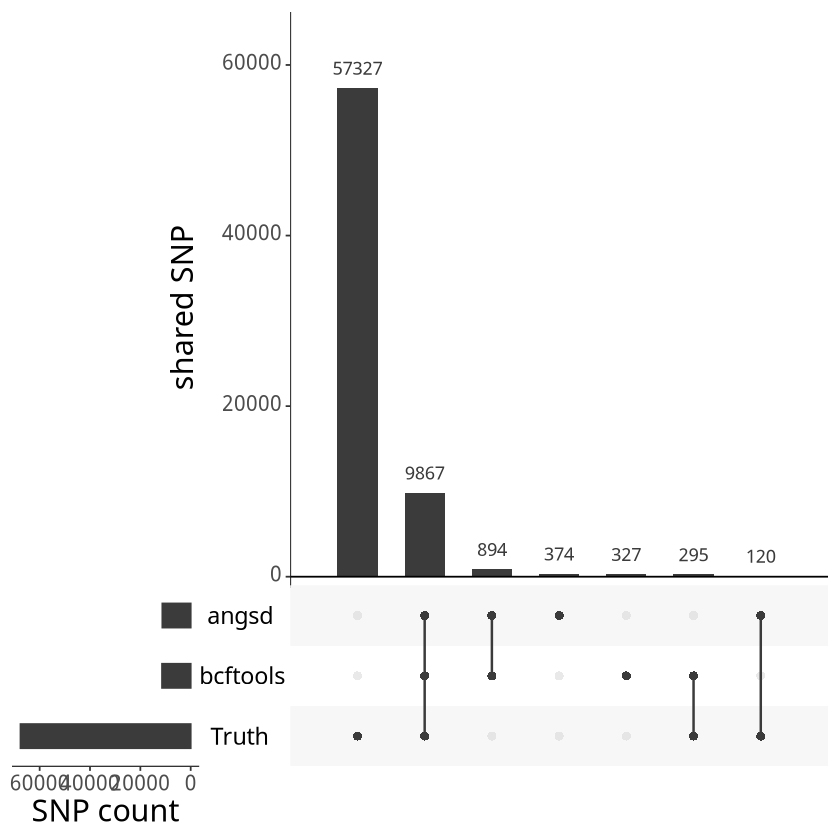

In [13]:
upset(
  upsetdf,
  order.by         = "freq",
  sets.x.label     = "SNP count",
  mainbar.y.label  = "shared SNP",
  text.scale = c(2.2, 1.8, 2.2, 1.8, 2, 1.8)
)

How many true SNPs were called of angsd and bcftools ?

How many untrue SNPs were called ?

See the last two columns, angsd has a bit less shared SNP with the truth. The reason is, angsd is mainly focusing and excellent on genotype likelihood estimation, but not genotype calling.

# Genotype calling with imputation

we will use several different strategies to impute the genotype.

## Genome data, genotype calling with Beagle 4 imputation

We should first preparing the information needed for imputation

As we already have genotype (likelihood) data called by angsd, we will just use those output.

Before that, we need to convert the data to vcf format, and build index, which is required for running Beagle 4 in genotype (likelihood) mode.

In [14]:
# prepare data for beagle 4, using angsd bcf output
if [ ! -d ${output_dir}/beagle4_out ]; then mkdir ${output_dir}/beagle4_out; fi
bcftools view ${output_dir}/angsd_out/angsd_genotype.bcf -Ov -o ${output_dir}/beagle4_out/angsd_for_beagle.vcf
bgzip -f ${output_dir}/beagle4_out/angsd_for_beagle.vcf
tabix -f ${output_dir}/beagle4_out/angsd_for_beagle.vcf.gz
 

(anders) (anders) (anders) (anders) (anders) 


Run the imputation based on the angsd genotype.
"gl" means genotype likelihood

In [15]:
# 10 secs to run
java -Xmx8g -jar ${BEAGLE4} \
    gl=${output_dir}/beagle4_out/angsd_for_beagle.vcf.gz \
    out=${output_dir}/beagle4_out/beagle4_imputation \
    niterations=10 \
    nthreads=32
bcftools index ${output_dir}/beagle4_out/beagle4_imputation.vcf.gz


(anders) beagle.27Jan18.7e1.jar (version 4.1)
Copyright (C) 2014-2015 Brian L. Browning
Enter "java -jar beagle.27Jan18.7e1.jar" for a summary of command line arguments.
Start time: 11:57 AM CST on 26 Jul 2025

Command line: java -Xmx8192m -jar beagle.jar
  gl=/home/tch_myname/sysu_day2_imputation/beagle4_out/angsd_for_beagle.vcf.gz
  out=/home/tch_myname/sysu_day2_imputation/beagle4_out/beagle4_imputation
  niterations=10
  nthreads=32

No genetic map is specified: using 1 cM = 1 Mb

reference samples:       0
target samples:         30

Window 1 [ chr20:2000377-4999859 ]
target markers:      11255

Starting burn-in iterations

Window=1 Iteration=1
Time for building model:         0 seconds
Time for sampling (singles):     0 seconds
DAG statistics
mean edges/level: 4      max edges/level: 10
mean edges/node:  1.946  mean count/edge: 15

Window=1 Iteration=2
Time for building model:         0 seconds
Time for sampling (singles):     0 seconds
DAG statistics
mean edges/level: 5      max

## Genome data, QUILT2 imputation + genotype calling

We will then play QUILT2. it will start from the bam file, do genotype calling and imputation.

Because it takes 20min to run all 30 samples, we will take 1 sample as an example, and use the prepared outcome of 30 samples for further comparison.

In [16]:
# 2 min to run
quilt_out=${output_dir}/quilt2_1_ind
if [ -d ${quilt_out}/ ]; then rm -rf ${quilt_out}/; fi
head -n 1 ${output_dir}/CEU_inds_bams.list > ${output_dir}/CEU_1_ind.list
$QUILT2 \
    --outputdir=${quilt_out} \
    --chr=chr20 \
    --regionStart=2000001 \
    --regionEnd=5000000 \
    --buffer=500000 \
    --nGen=100 \
    --bamlist=${output_dir}/CEU_1_ind.list \
    --genetic_map_file=${QUILT2_MAP} \
    --reference_vcf_file=${REF_VCF} \
    --save_prepared_reference=TRUE


(anders) (anders) (anders) (anders) 警告信息:
1: 程序包‘QUILT’是用R版本4.4.3 来建造的 
2: 程序包‘STITCH’是用R版本4.4.3 来建造的 
3: 程序包‘mspbwt’是用R版本4.4.3 来建造的 
4: 程序包‘data.table’是用R版本4.4.3 来建造的 
[2025-07-26 11:57:24] Running QUILT(outputdir = /home/tch_myname/sysu_day2_imputation/quilt2_1_ind, chr = chr20, method = diploid, regionStart = 2000001, regionEnd = 5000000, buffer = 500000, fflist = , bamlist = /home/tch_hemyname/sysu_day2_imputation/CEU_1_ind.list, cramlist = , sampleNames_file = , reference = , nCores = 1, nGibbsSamples = 7, n_seek_its = 3, n_burn_in_seek_its = NA, Ksubset = 600, Knew = 600, K_top_matches = 5, output_gt_phased_genotypes = TRUE, heuristic_match_thin = 0.1, output_filename = NULL, RData_objects_to_save = NULL, output_RData_filename = NULL, prepared_reference_filename = , save_prepared_reference = TRUE, tempdir = NA, bqFilter = 17, useSoftClippedBases = FALSE, panel_size = NA, posfile = , genfile = , phasefile = , maxDifferenceBetweenReads = 1e+10, make_plots = FALSE, make_plots_block_

In [17]:

# it takes 20 min to run for all individuals, we will just copy the prepared results
#quilt_out=${output_dir}/quilt2_output
#if [ -d quiltout];thenrm−rfquilt_out; fi
#$QUILT2 \
#    --outputdir=${quilt_out} \
#    --chr=chr20 \
#    --regionStart=2000001 \
#    --regionEnd=5000000 \
#    --buffer=500000 \
#    --nGen=100 \
#    --bamlist=${output_dir}/CEU_inds_bams.list \
#    --genetic_map_file=${QUILT2_MAP} \
#    --reference_vcf_file=${REF_VCF} \
#    --save_prepared_reference=TRUE

cp ${QUILT2_EXAMPLE} ${output_dir}/quilt2_1_ind/quilt2_all_inds.vcf.gz
tabix ${output_dir}/quilt2_1_ind/quilt2_all_inds.vcf.gz


(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) 


## SNP-chip data Beagle 5.5 imputation

Beagle 5.5 supports large reference panel. which could help improve the accuracy.

In [18]:
# 3 secs to run
if [ ! -d ${output_dir}/beagle5_out ]; then mkdir ${output_dir}/beagle5_out ; fi

java -Xmx8g -jar $BEAGLE5 \
    gt=${FAKE_SNPCHIP} \
    ref=${REF_VCF} \
    map=${BEAGLE5_MAP} \
    nthreads=16 \
    impute=true \
    gp=true \
    out=${output_dir}/beagle5_out/beagle5_imputed

bcftools index ${output_dir}/beagle5_out/beagle5_imputed.vcf.gz


(anders) (anders) (anders) beagle.27Feb25.75f.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.27Feb25.75f.jar" to list command line argument
Start time: 11:58 AM CST on 26 Jul 2025

Command line: java -Xmx8192m -jar beagle.27Feb25.75f.jar
  gt=/home/tch_wyd/myname/inputs/imputation/vcfs/CEU_fake_chip.chr20.vcf.gz
  ref=/home/tch_wyd/myname/inputs/imputation/vcfs/CEU_ref_set.chr20.vcf.gz
  map=/home/tch_wyd/myname/shared/data/plink.GRCh38.map/plink.chr20.GRCh38.rename.map
  nthreads=16
  impute=true
  gp=true
  out=/home/tch_myname/sysu_day2_imputation/beagle5_out/beagle5_imputed

Reference samples:                   69
Study     samples:                   30

Window 1 [chr20:2000004-4999999]
Reference markers:               79,788
Study     markers:                1,144

Imputation time:               1 second

Cumulative Statistics:

Reference markers:               79,788
Study     markers:                1,144

Imputation time:               1 sec

# Compare results from tools

Lets first copy the true VCF results

In [19]:
cp -sf ${TRUE_VCF} ${output_dir}/
tabix -f ${output_dir}/CEU_true_set.chr20.vcf.gz

(anders) (anders) 


In [20]:
# load the function
library(vcfppR)

estimate_gt_tools <- function(gt_mat_list = list(), gt_true_mat=matrix(), keep=c()){
    if(!all(lapply(gt_mat_list, nrow) == nrow(gt_true_mat))){stop("SNP count doesn't match")}
    if(!all(lapply(gt_mat_list, ncol) == ncol(gt_true_mat))){stop("Sample count doesn't match")}
    if(length(keep)==0){
        keep <- rep(TRUE, nrow(gt_true_mat))
    }
    res <- 
    sapply(gt_mat_list,function(x){
        x[is.na(x)] <- -1;
      mean(res_truth_mat[keep, ]==x[keep, ],na.rm=T)})
    
    resMis <- sapply(gt_mat_list,function(x) 
      mean(is.na(x[keep, ]),na.rm=T))
    resNA <- 
    sapply(gt_mat_list,function(x) 
      mean(res_truth_mat[keep, ]==x[keep, ],na.rm=T))
    
    cat("Missing genotype rate:\n")
    print(resMis)
    
    cat("\nDiscordance rate assuming missing is discordant:\n")
    print(res)
    
    cat("\nDiscordance rate when ignoring missing genotypes:\n")
    print(resNA)
}
           
gp_to_gq <- function(gp_row) {
  if (any(is.na(gp_row))) return(0)  # NA to 0
  p_max <- max(gp_row)
  if (p_max >= 0.999999) return(99)  # cap GQ at 99
  gq <- -10 * log10(1 - p_max)
  return(round(gq, 2))
}

In [21]:
# Read all data

gt_truth_file <- paste0(work_d, "/CEU_true_set.chr20.vcf.gz")
gt_bcftool_file <- paste0(work_d, "/bcftoolsgt_out/CEU_inds_bam.vcf.gz")
gt_angsd_file <- paste0(work_d, "/angsd_out/angsd_genotype.bcf")
gt_beagle4gl_file <- paste0(work_d, "/beagle4_out/beagle4_imputation.vcf.gz")
gt_quilt2_file <- paste0(work_d, "/quilt2_1_ind/quilt2_all_inds.vcf.gz")
gt_beagle5gl_file <- paste0(work_d, "/beagle5_out/beagle5_imputed.vcf.gz")


res_truth <- vcftable(gt_truth_file, "chr20:2000001-5000000", vartype = "snps")
res_bcftools <- vcftable(gt_bcftool_file, "chr20:2000001-5000000", vartype = "snps")
res_angsd <- vcftable(gt_angsd_file, "chr20:2000001-5000000", vartype = "snps")
res_beagle4gl <- vcftable(gt_beagle4gl_file, "chr20:2000001-5000000", vartype = "snps")
res_quilt2 <- vcftable(gt_quilt2_file, "chr20:2000001-5000000", vartype = "snps")
res_beagle5gl <- vcftable(gt_beagle5gl_file, "chr20:2000001-5000000", vartype = "snps")


res_truth$samples <- sub(".lc.bam", "", basename(res_truth$samples))
res_bcftools$samples <- sub(".lc.bam", "", basename(res_bcftools$samples))
res_angsd$samples <- sub(".lc.bam", "", basename(res_angsd$samples))
res_beagle4gl$samples <- sub(".lc.bam", "", basename(res_beagle4gl$samples))
res_quilt2$samples <- sub(".lc.bam", "", basename(res_quilt2$samples))
res_beagle5gl$samples <- sub(".lc.bam", "", basename(res_beagle5gl$samples))



In [22]:
true_freq <- rowMeans(res_truth$gt)/2
table(true_common <- true_freq > 0.05 & true_freq < 0.95)


FALSE  TRUE 
60639  7592 

In [23]:
names(res_truth)

[1] "samples" "chr"     "pos"     "id"      "ref"     "alt"     "qual"   
 [8] "filter"  "info"    "gt"

In [24]:
res_truth_mat <- res_truth$gt
res_bcftools_mat <- find_match(res_bcftools, res_truth, name="bcftools")
res_angsd_mat <- find_match(res_angsd, res_truth, name="angsd")
res_beagle4gl_mat <- find_match(res_beagle4gl, res_truth, name="beagle4gl")
res_beagle5gl_mat <- find_match(res_beagle5gl, res_truth, name="beagle5gl")
res_quilt2_mat <- find_match(res_quilt2, res_truth, name="quilt2")


In [25]:
estimate_gt_tools(list(
    bcftools=res_bcftools_mat,
    angsd=res_angsd_mat,
    beagle4gl=res_beagle4gl_mat,
    beagle5gl=res_beagle5gl_mat,
    quilt2=res_quilt2_mat), res_truth_mat)

Missing genotype rate:
 bcftools     angsd beagle4gl beagle5gl    quilt2 
0.8533970 0.8561138 0.8510794 0.0000000 0.0000000 

Discordance rate assuming missing is discordant:
 bcftools     angsd beagle4gl beagle5gl    quilt2 
0.1353354 0.1305741 0.1437988 0.9927999 0.9968118 

Discordance rate when ignoring missing genotypes:
 bcftools     angsd beagle4gl beagle5gl    quilt2 
0.9231420 0.9074815 0.9656071 0.9927999 0.9968118 


In [26]:
estimate_gt_tools(list(
    bcftools=res_bcftools_mat,
    angsd=res_angsd_mat,
    beagle4gl=res_beagle4gl_mat,
    beagle5gl=res_beagle5gl_mat,
    quilt2=res_quilt2_mat), res_truth_mat, keep=true_common)

Missing genotype rate:
   bcftools       angsd   beagle4gl   beagle5gl      quilt2 
0.039756762 0.039493326 0.006190727 0.000000000 0.000000000 

Discordance rate assuming missing is discordant:
 bcftools     angsd beagle4gl beagle5gl    quilt2 
0.8728442 0.8596505 0.9659817 0.9610335 0.9915525 

Discordance rate when ignoring missing genotypes:
 bcftools     angsd beagle4gl beagle5gl    quilt2 
0.9089824 0.8949969 0.9719991 0.9610335 0.9915525 
